# **Modelling and Evaluating**

## Objectives

* Answer business requirement 2:
    - The client is interested in predicting if a cherry leaf is healthy or contains powdery mildew.

## Inputs

* inputs/cherryleaves_dataset/cherry-leaves/train
* inputs/cherryleaves_dataset/cherry-leaves/test
* inputs/cherryleaves_dataset/cherry-leaves/validation
* image shape embeddings

## Outputs

* Image distribution in train, validation and test set.
* Image augmentation.
* Class indices to change prediction inference in labels.
* Machine learning model creation and training.
* Save model.
* Learning curve plot for model performance.
* Model evaluation on pickle file.
* Prediction on the random image file.


## Additional Comments




---

## Import Packages

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.image import imread

---

## Set working directory

In [2]:
current_dir = os.getcwd()
current_dir

'/workspace/mildew-detection-in-cherry-leaves/jupyter_notebooks'

In [3]:
os.chdir(os.path.dirname(current_dir))
print("You set a new current directory")

You set a new current directory


In [4]:
current_dir = os.getcwd()
current_dir

'/workspace/mildew-detection-in-cherry-leaves'

---

## Set Input Directories

Set train, validation and test paths.

In [5]:
my_data_dir = 'inputs/cherryleaves_dataset/cherry-leaves'
train_path = my_data_dir + '/train'
validation_path = my_data_dir + '/validation'
test_path = my_data_dir + '/test'

---

## Set Output Directory

In [6]:
version = 'v1'
file_path = f'outputs/{version}'

if 'outputs' in os.listdir(current_dir) and version in os.listdir(current_dir + '/outputs'):
    print('Old version is already available create a new version.')
    pass
else:
    os.makedirs(name=file_path)

Old version is already available create a new version.


---

## Set Label Names

In [7]:

labels = os.listdir(train_path)

print(
    f"Labels for the images are {labels}"
)

Labels for the images are ['healthy', 'powdery_mildew']


---

## Set Image Shape

In [8]:
import joblib
version = 'v1'
image_shape = joblib.load(filename=f"outputs/{version}/image_shape.pkl")
image_shape

(256, 256, 3)

---

# Images Distribution

Check distribution of images across the train, validation, and test datasets.

* train - healthy: 1472 images
* train - powdery_mildew: 1472 images
* validation - healthy: 210 images
* validation - powdery_mildew: 210 images
* test - healthy: 422 images
* test - powdery_mildew: 422 images




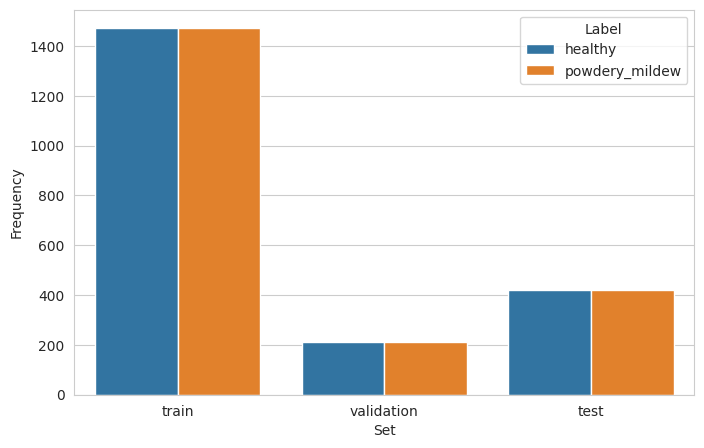

In [9]:
df_freq = pd.DataFrame([])
for folder in ['train', 'validation', 'test']:
    for label in labels:
        df_freq = df_freq.append(
            pd.Series(data={'Set': folder,
                            'Label': label,
                            'Frequency': int(len(os.listdir(my_data_dir + '/' + folder + '/' + label)))}
                      ),
            ignore_index=True
        )

        print(
            f"* {folder} - {label}: {len(os.listdir(my_data_dir+'/'+ folder + '/' + label))} images")

print("\n")
sns.set_style("whitegrid")
plt.figure(figsize=(8, 5))
sns.barplot(data=df_freq, x='Set', y='Frequency', hue='Label')
plt.savefig(f'{file_path}/labels_distribution.png',
            bbox_inches='tight', dpi=150)
plt.show()


---

# Image Data Augmentation

#### Import ImageDataGenerator

In [10]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

#### Initialise ImageDataGenerator

In [11]:
augmented_image_data = ImageDataGenerator(rotation_range=20,
                                          width_shift_range=0.10,
                                          height_shift_range=0.10,
                                          shear_range=0.1,
                                          zoom_range=0.1,
                                          horizontal_flip=True,
                                          vertical_flip=True,
                                          fill_mode='nearest',
                                          rescale=1./255
                                          )

---

### Augment Training Image Set

In [12]:
batch_size = 16

In [13]:
train_set = augmented_image_data.flow_from_directory(train_path,
                                                     target_size=image_shape[:2],
                                                     color_mode='rgb',
                                                     batch_size=batch_size,
                                                     class_mode='binary',
                                                     shuffle=True
                                                     )

train_set.class_indices

Found 2944 images belonging to 2 classes.


{'healthy': 0, 'powdery_mildew': 1}

### Plot Augmented Training Image Set

(16, 256, 256, 3)


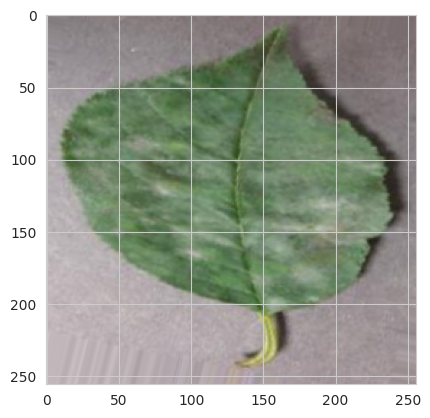

(16, 256, 256, 3)


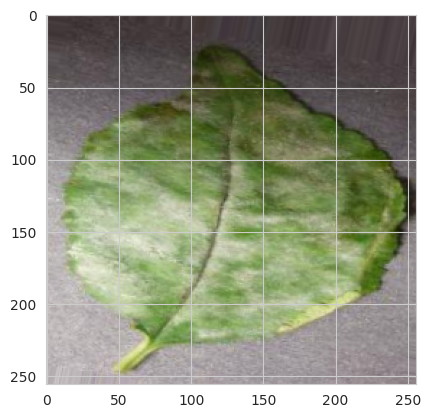

(16, 256, 256, 3)


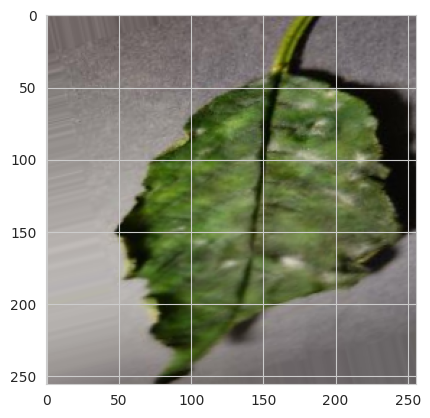

In [14]:
for _ in range(3):
    img, label = train_set.next()
    print(img.shape)
    plt.imshow(img[0])
    plt.show()

### Augment Validation Image Set

In [15]:
validation_set = ImageDataGenerator(rescale=1./255).flow_from_directory(validation_path,
                                                                        target_size=image_shape[:2],
                                                                        color_mode='rgb',
                                                                        batch_size=batch_size,
                                                                        class_mode='binary',
                                                                        shuffle=False
                                                                        )

validation_set.class_indices

Found 420 images belonging to 2 classes.


{'healthy': 0, 'powdery_mildew': 1}

### Plot Augmented Validation Image Set

(16, 256, 256, 3)


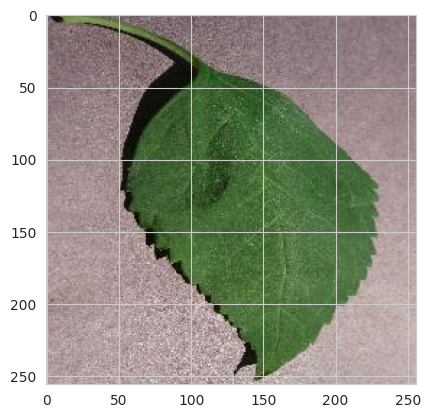

(16, 256, 256, 3)


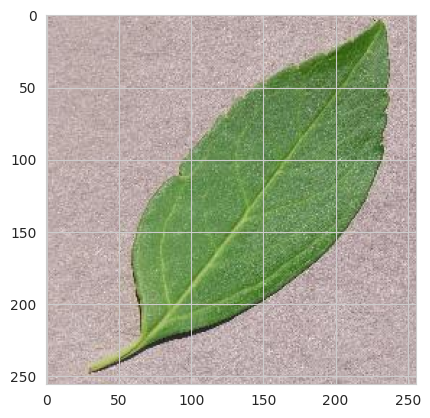

(16, 256, 256, 3)


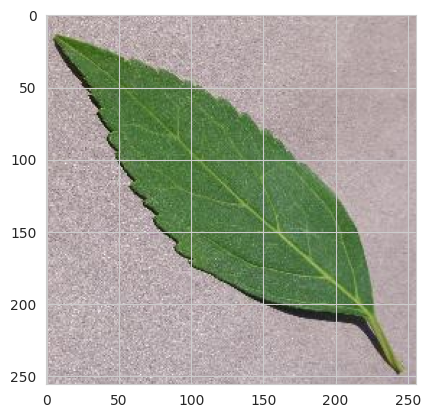

In [16]:
for _ in range(3):
    img, label = validation_set.next()
    print(img.shape)
    plt.imshow(img[0])
    plt.show()

### Augment Test Image Set

In [17]:
test_set = ImageDataGenerator(rescale=1./255).flow_from_directory(test_path,
                                                                  target_size=image_shape[:2],
                                                                  color_mode='rgb',
                                                                  batch_size=batch_size,
                                                                  class_mode='binary',
                                                                  shuffle=False
                                                                  )

test_set.class_indices

Found 844 images belonging to 2 classes.


{'healthy': 0, 'powdery_mildew': 1}

### Plot Augmented Test Image Set

(16, 256, 256, 3)


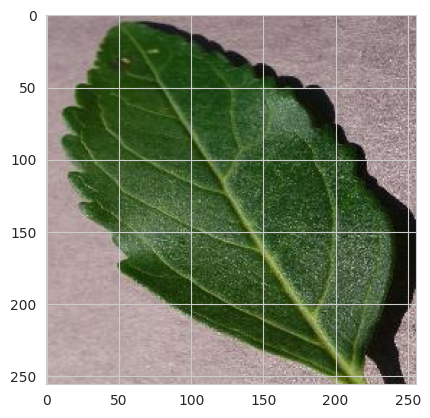

(16, 256, 256, 3)


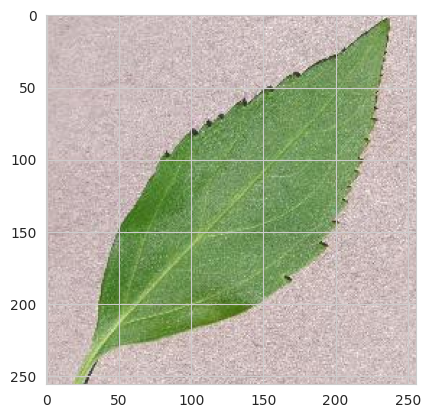

(16, 256, 256, 3)


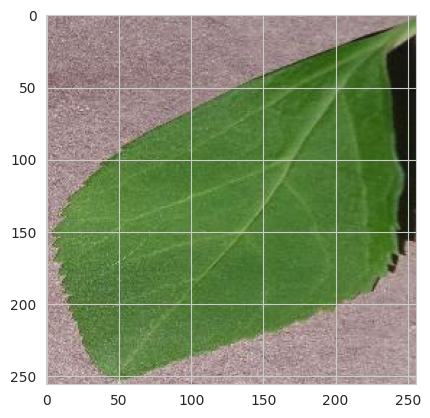

In [18]:
for _ in range(3):
    img, label = test_set.next()
    print(img.shape)
    plt.imshow(img[0])
    plt.show()

### Save class_indices

In [19]:
joblib.dump(value=train_set.class_indices,
            filename=f"{file_path}/class_indices.pkl")

['outputs/v1/class_indices.pkl']

---

# Model Creation



---

### Import Packages

In [20]:
from tensorflow.keras.models import Sequential
from tensorflow.keras import models, layers, regularizers
from tensorflow.keras.layers import Activation, Dropout, Flatten, Dense, Conv2D, MaxPooling2D, BatchNormalization, LeakyReLU
from tensorflow.keras.optimizers import RMSprop, Adam, Adagrad

## ML Model

In [28]:
def create_tf_model():
    model = Sequential()

    ### input layer
    model.add(Conv2D(filters=32, kernel_size=(3,3),
              input_shape=image_shape, activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    ### convolutional layers
    model.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Flatten())

    model.add(Dense(64, activation='relu'))

    model.add(Dropout(0.5))

    model.add(Dense(1, activation='sigmoid'))

    model.compile(loss='binary_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])

    return model




### Model Summary

In [29]:
create_tf_model().summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 254, 254, 32)      896       
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 127, 127, 32)      0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 125, 125, 64)      18496     
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 62, 62, 64)        0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 60, 60, 64)        36928     
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 30, 30, 64)        0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 57600)            

### Early Stopping

In [30]:
from tensorflow.keras.callbacks import EarlyStopping
early_stop = EarlyStopping(monitor='val_loss', patience=3)

### Fit Model For Training

In [31]:
model = create_tf_model()
model.fit(train_set,
          batch_size=batch_size,
          epochs=30,
          steps_per_epoch=len(train_set.classes)//batch_size,
          validation_data=validation_set,
          callbacks=[early_stop],
          verbose=1,
          )


Epoch 1/30
184/184 [==============================] - 279s 2s/step - loss: 0.4401 - accuracy: 0.7972 - val_loss: 0.0561 - val_accuracy: 0.9857
Epoch 2/30
184/184 [==============================] - 270s 1s/step - loss: 0.1102 - accuracy: 0.9660 - val_loss: 0.0239 - val_accuracy: 0.9905
Epoch 3/30
184/184 [==============================] - 261s 1s/step - loss: 0.0864 - accuracy: 0.9691 - val_loss: 0.0667 - val_accuracy: 0.9810
Epoch 4/30
184/184 [==============================] - 259s 1s/step - loss: 0.1294 - accuracy: 0.9521 - val_loss: 0.0525 - val_accuracy: 0.9857
Epoch 5/30
184/184 [==============================] - 254s 1s/step - loss: 0.0592 - accuracy: 0.9803 - val_loss: 0.0399 - val_accuracy: 0.9857


### Save Model

In [32]:
model.save('outputs/v1/mildew_detector_model.h5')

---

# Model Performance

---

### Model Learning Curve

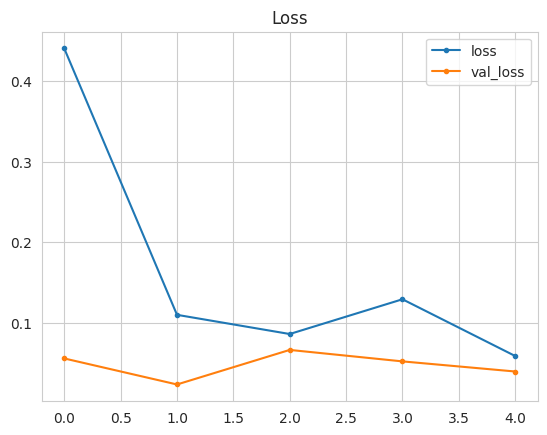

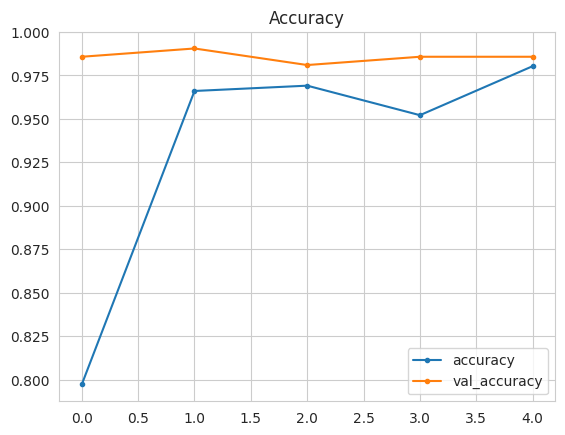

In [33]:
losses = pd.DataFrame(model.history.history)

sns.set_style("whitegrid")
losses[['loss', 'val_loss']].plot(style='.-')
plt.title("Loss")
plt.savefig(f'{file_path}/model_training_losses.png',
            bbox_inches='tight', dpi=150)
plt.show()

print("\n")
losses[['accuracy', 'val_accuracy']].plot(style='.-')
plt.title("Accuracy")
plt.savefig(f'{file_path}/model_training_acc.png',
            bbox_inches='tight', dpi=150)
plt.show()


## Model Evaluation

### Load saved model

In [34]:
from keras.models import load_model
model = load_model('outputs/v1/mildew_detector_model.h5')

### Evaluate model on test set

In [35]:
evaluation = model.evaluate(test_set)

53/53 [==============================] - 16s 306ms/step - loss: 0.0387 - accuracy: 0.9882


### Save evaluation pickle

In [36]:
joblib.dump(value=evaluation,
            filename=f"outputs/v1/evaluation.pkl")

['outputs/v1/evaluation.pkl']

## Predict on New Data

#### Load a random image as PIL

Image shape: (256, 256), Image mode: RGB


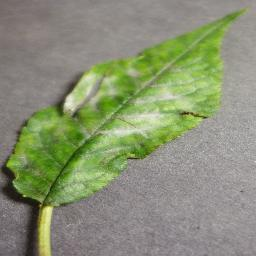

In [40]:
from tensorflow.keras.preprocessing import image

pointer = 52
label = labels[1]

target_size = (256, 256)

pil_image = image.load_img(test_path + '/' + label + '/' + os.listdir(test_path+'/' + label)[pointer],
                           target_size=target_size, color_mode='rgb')

print(f'Image shape: {pil_image.size}, Image mode: {pil_image.mode}')
pil_image

Convert image to array and prepare for prediction

In [41]:
my_image = image.img_to_array(pil_image)
my_image = np.expand_dims(my_image, axis=0)/255.0 
print(my_image.shape)

(1, 256, 256, 3)


Predict class probabilities

In [42]:
pred_proba = model.predict(my_image)[0, 0]

target_map = {v: k for k, v in train_set.class_indices.items()}
pred_class = target_map[pred_proba > 0.5]

if pred_class == target_map[0]:
    pred_proba = 1 - pred_proba

print(pred_proba)
print(pred_class)


0.99999356
powdery_mildew
